### RSI Trading

download data -> 
construct_signals (rsi) -> 
simluate (trading strategy) ->
plot1 for signal -> 
plot2 for PnL --> 
show_stats (profit; autual capital; sharpe ratio)

#### [Returns and log returns]

**- Arithmetic Returns**

$R(t) = \frac{S(t+1)-S(t)}{S(t)}$

**- Log Returns**

$r_t = \log(\frac{S(t+1)}{S(t)})$

- why log returns? Becasue when we want to calculate return for next n periods and keeps it normalized!!
- Arithmetic Returns are calculated by "multiply the returns"; Log Returns can got by suming up, that way can get it normalized. 

$\frac{S(t+n)}{S(t)} = \frac{S(t+1)}{S(t)}*\frac{S(t+2)}{S(t+1)}*...*\frac{S(t+n)}{S(t+n+1)}$

$\implies = (1+R_\text{t+1})*(1+R_\text{t+2})*...*(1+R_\text{t+n})$

$\implies = \log[(1+R_\text{t+1})*(1+R_\text{t+2})*...*(1+R_\text{t+n})]$

$\implies = r_t+r_\text{t+1}+...+r_\text{t+n}$

In [1]:
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import datetime
import pandas as pd


class MovingAverageRSIStrategy:

    def __init__(self, capital, stock, start, end, short_period, long_period):
        self.data = None
        self.is_long = False
        self.short_period = short_period
        self.long_period = long_period
        self.capital = capital
        self.equity = [capital]
        self.stock = stock
        self.start = start
        self.end = end

    def download_data(self):
        stock_data = {}
        ticker = yf.download(self.stock, self.start, self.end)
        stock_data['price'] = ticker['Adj Close']
        self.data = pd.DataFrame(stock_data)

    def construct_signals(self):
        self.data['short_ma'] = self.data['price'].ewm(span=self.short_period).mean()
        self.data['long_ma'] = self.data['price'].ewm(span=self.long_period).mean()
        self.data['move'] = self.data['price'] - self.data['price'].shift(1)
        self.data['up'] = np.where(self.data['move'] > 0, self.data['move'], 0)
        self.data['down'] = np.where(self.data['move'] < 0, self.data['move'], 0)
        self.data['average_gain'] = self.data['up'].rolling(14).mean()
        self.data['average_loss'] = self.data['down'].abs().rolling(14).mean()
        relative_strength = self.data['average_gain'] / self.data['average_loss']
        self.data['rsi'] = 100.0 - (100.0 / (1.0 + relative_strength))
        self.data = self.data.dropna()
        print(self.data)

    def plot_signals(self):
        plt.figure(figsize=(12, 6))
        plt.plot(self.data['price'], label='Stock Price')
        plt.plot(self.data['short_ma'], label='Short MA', color='blue')
        plt.plot(self.data['long_ma'], label='Long MA', color='green')
        plt.title('Moving Average (MA) Crossover Trading Strategy with RSI')
        plt.xlabel('Date')
        plt.ylabel('Stock Price')
        plt.show()

    def simulate(self):
        price_when_buy = 0

        for index, row in self.data.iterrows():
            if row['short_ma'] < row['long_ma'] and self.is_long:
                self.equity.append(row['price'] * self.capital / price_when_buy)
                self.is_long = False
            elif row['short_ma'] > row['long_ma'] and not self.is_long \
                    and row['rsi'] < 30:
                price_when_buy = row['price']
                self.is_long = True

    def plot_equity(self):
        plt.figure(figsize=(12, 6))
        plt.title('Equity Curve')
        plt.plot(self.equity, label='Stock Price', color='green')
        plt.xlabel('Date')
        plt.ylabel('Capital ($)')
        plt.show()
    
    #sharpe ratio = how much excess return you're receiving for extra volatility that you endure
    #sharpe ratio = (r(p) - r(f))/sigma(p). Here we assume r(f) = 0
    #sharpe ratio is the higher the better 
    def show_stats(self):
        print("Profit of the trading strategy: %.2f%%" % (
                (float(self.equity[-1]) - float(self.equity[0])) /
                float(self.equity[0]) * 100))
        print("Actual capital: %0.2f" % self.equity[-1])
        returns = (self.data['price'] - self.data['price'].shift(1)) / self.data['price'].shift(1)
        ratio = returns.mean() / returns.std() * np.sqrt(252)
        print('Sharpe ratio: %.2f' % ratio)

[*********************100%***********************]  1 of 1 completed
                                price    short_ma     long_ma      move  \
Date                                                                      
2010-01-22 00:00:00-05:00   76.113022   79.064866   79.122238 -2.122696   
2010-01-25 00:00:00-05:00   76.489044   78.826761   78.929837  0.376022   
2010-01-26 00:00:00-05:00   76.264626   78.599828   78.746090 -0.224419   
2010-01-27 00:00:00-05:00   76.616425   78.430877   78.607011  0.351799   
2010-01-28 00:00:00-05:00   75.051704   78.153142   78.386319 -1.564720   
...                               ...         ...         ...       ...   
2019-12-24 00:00:00-05:00  109.874344  109.684281  110.040292 -0.463982   
2019-12-26 00:00:00-05:00  109.817352  109.690772  110.037339 -0.056992   
2019-12-27 00:00:00-05:00  110.110397  109.711242  110.038307  0.293045   
2019-12-30 00:00:00-05:00  108.107948  109.633032  110.012739 -2.002449   
2019-12-31 00:00:00-05:00  109.

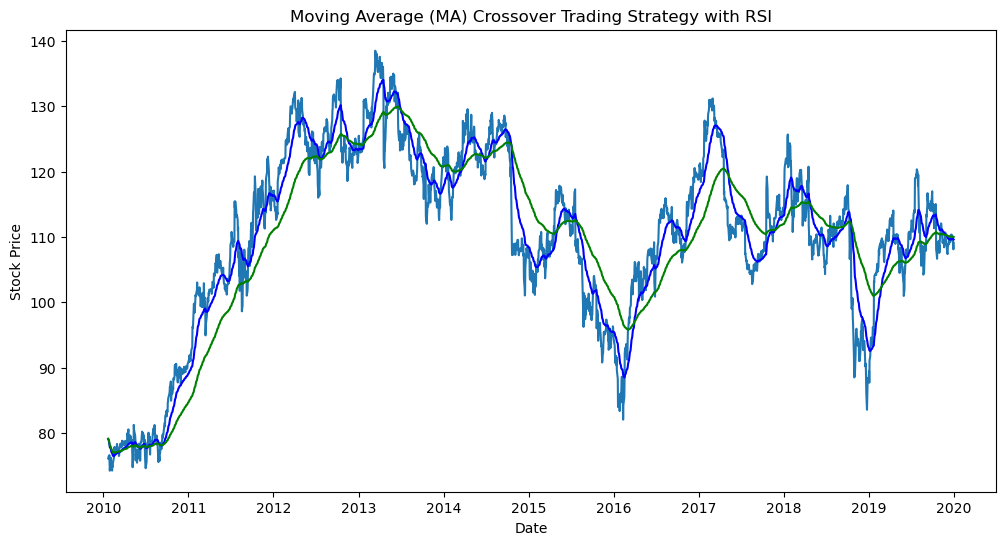

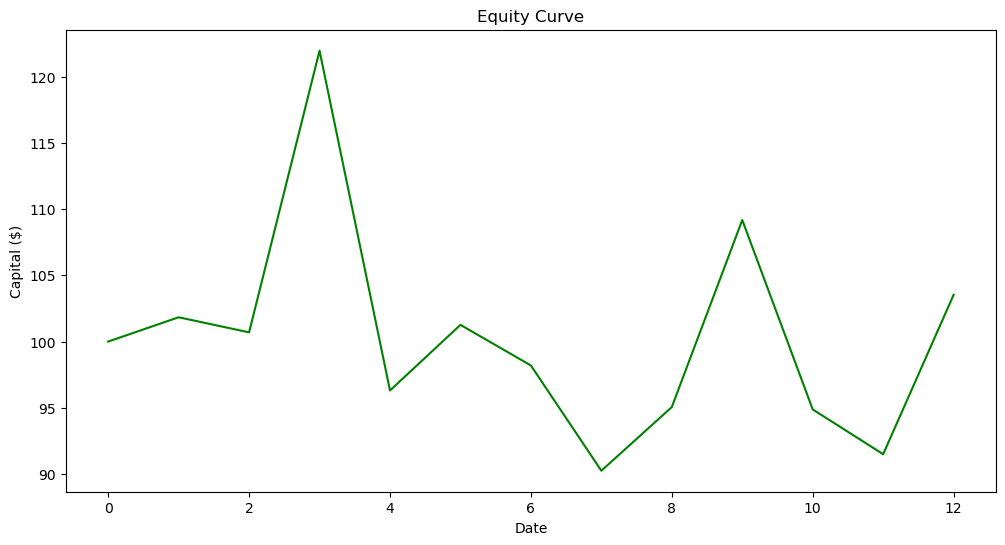

Profit of the trading strategy: 3.53%
Actual capital: 103.53
Sharpe ratio: 0.28


In [2]:
if __name__ == '__main__':
    start_date = datetime.datetime(2010, 1, 1)
    end_date = datetime.datetime(2020, 1, 1)

    model = MovingAverageRSIStrategy(100, 'IBM', start_date, end_date, 40, 150)
    model.download_data()
    model.construct_signals()
    model.plot_signals()
    model.simulate()
    model.plot_equity()
    model.show_stats()